<a href="https://colab.research.google.com/github/marketakvasova/segmentation/blob/main/automatic_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [216]:
!python --version

Python 3.10.12


# **Automatic segmentation of electron microscope images**

# 1. Setup

In [217]:
import os
from google.colab import drive
import torch.cuda
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset
# import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

drive.flush_and_unmount()
drive.mount('/content/gdrive')
model_folder = "./gdrive/MyDrive/ROI_patches/my_model"
os.makedirs(model_folder, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # TODO: do not even try this, if the gpu is not connected

biomodel_folder = os.path.join(model_folder, "bioimageio_model")
biomodel_path = os.path.join(biomodel_folder, "weights.pt")
os.makedirs(biomodel_folder, exist_ok=True)

Mounted at /content/gdrive


# Utils

## Data utils

In [218]:
class MyDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transofrm=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transofrm
    self.images = sorted(os.listdir(self.image_dir)) # listdir returns arbitrary order
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.masks[index]) # mask and image need to be called the same
    image = np.array(Image.open(img_path).convert('L')) # TODO: only grayscale images
    mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
    mask[mask == 255.0] = 1
    return image, mask

class TransformDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    image, mask = self.dataset[index]
    augmentations = self.transform(image=image, mask=mask)
    image = augmentations["image"]
    mask = augmentations["mask"]
    return image, mask

  def __len__(self):
    return len(self.dataset)


def get_loaders(img_dir, mask_dir, split, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
  data = MyDataset(
    image_dir=img_dir,
    mask_dir=mask_dir,
    transofrm=None
  )

  train_indices, test_indices = train_test_split(
    range(len(data)),
    test_size=split,
    random_state=42
  )
  train_data = TransformDataset(Subset(data, train_indices), train_transform)
  val_data = TransformDataset(Subset(data, test_indices), val_transform)

  train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
  )

  val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=False
  )

  return train_loader, val_loader, train_indices

## Training utils

In [219]:
def save_checkpoint(state):#, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  model.save(biomodel_path)
  # torch.save(state, filename)

def save_state_dict(model):
  print("=> Saving checkpoint")
  torch.save(model.state_dict(), biomodel_path)

# def load_checkpoint(checkpoint, model):
#     print("=> Loading checkpoint")
#     model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, val_losses, dice_scores, device, loss_fn):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()
  running_loss = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1) # label is grayscale
      # preds = torch.softmax(model(x), dim=1)
      preds = torch.sigmoid(model(x))
      loss = loss_fn(preds, y)
      running_loss += loss.cpu()
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum()) / (preds+y).sum() + 1e-8 # this is a better predictor
  print(
    f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} ()"
  )
  dice_score = dice_score/len(loader)
  print(f"Dice score is {dice_score}")
  val_losses.append(running_loss/len(loader))
  dice_scores.append(dice_score.cpu())
  model.train()
  return dice_score

# def save_predictions_as_imgs(
#         loader, model, folder="saved_images", device="cpu"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         # print(f"preds max{preds.max()}")
#         # print(f"y max {y.max()}")
#         # torchvision.utils.save_image(preds, os.path.join(folder, f"pred{idx}.png"))
#         # torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder, f"pred{idx}_correct.png"))
#             imshow(preds)
#             imshow(y.unsqueeze(1))
#         break # TODO: change this so it does not loop
#     model.train()
#     print("Saving prediction as images.")

def view_prediction(loader, model, device="cpu"):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device=device)
    with torch.no_grad():
      # output = torch.softmax(model(x), dim=1)
      output = torch.sigmoid(model(x))
      preds = (output > 0.5).float()
      preds = preds.cpu().data.numpy()
      output = output.cpu().data.numpy()
      for i in range(preds.shape[0]):
        f=plt.figure(figsize=(128,32))
        # Original image
        plt.subplot(1,5*preds.shape[0],i+1)
        x = x.cpu()
        plt.imshow(x[i, 0, :, :], cmap='gray') # preds is a batch
        plt.title('Validation image')
        # NN output(probability)
        plt.subplot(1,5*preds.shape[0],i+2)
        plt.imshow(output[i, 0, :, :], interpolation='nearest', cmap='magma') # preds is a batch
        plt.title('NN output')
        # Segmentation
        plt.subplot(1,5*preds.shape[0],i+3)
        plt.imshow(preds[i, 0, :, :], cmap='gray') # preds is a batch
        plt.title('Prediction')
        # True mask
        plt.subplot(1,5*preds.shape[0],i+4)
        plt.imshow(y.unsqueeze(1)[i, 0, :, :], cmap='gray')
        plt.title('Ground truth')
        # IoU
        plt.subplot(1,5*preds.shape[0],i+5)
        im1 = y.unsqueeze(1)[i, 0, :, :]
        im2 = preds[i, 0, :, :]
        plt.imshow(im1, alpha=0.8, cmap='Blues')
        plt.imshow(im2, alpha=0.6,cmap='Oranges')
        plt.title('IoU')
      plt.show()
      break # TODO: change this so it does not loop
  model.train()


def getClassWeights(mask_path, train_indices):

  mask_dir_list = sorted(os.listdir(mask_path))
  class_count = np.zeros(2, dtype=int)
  for i in train_indices:
    mask = np.array(Image.open(os.path.join(mask_path, mask_dir_list[i])).convert('L'), dtype=np.float32)
    mask[mask == 255.0] = 1
    class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
    class_count[1] += mask.sum()

  n_samples = class_count.sum()
  n_classes = 2

  class_weights = n_samples / (n_classes * class_count)
  return torch.from_numpy(class_weights)

# U-Net definition

In [220]:
# import torchvision.transforms.functional as TF


def double_conv(in_ch, out_ch):
  conv = nn.Sequential(
    nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
    nn.BatchNorm2d(out_ch),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
    nn.BatchNorm2d(out_ch),
    nn.ReLU(inplace=True)
  )

  return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor


def padder(left_tensor, right_tensor, device: str):
  # left_tensor is the tensor on the encoder side of UNET
  # right_tensor is the tensor on the decoder side  of the UNET

  if left_tensor.shape != right_tensor.shape:
    padded = torch.zeros(left_tensor.shape)
    padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
    return padded.to(device)

  return right_tensor.to(device)



class UNET(nn.Module):
  def __init__(self, in_channels, out_channels, device):
    super(UNET, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.device = device

    self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

    self.down_conv_1 = double_conv(in_ch=self.in_channels,out_ch=64)
    self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
    self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
    self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
    self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
    #print(self.down_conv_1)

    self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
    self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
    self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
    self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

    self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
    self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
    self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
    self.up_conv_4 = double_conv(in_ch=128,out_ch=64)

    self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.out_channels,kernel_size=1,stride=1)

  def forward(self, x):
    x = x.to(self.device)
    x1 = self.down_conv_1(x)
    p1 = self.max_pool(x1)
    x2 = self.down_conv_2(p1)
    p2 = self.max_pool(x2)
    x3 = self.down_conv_3(p2)
    p3 = self.max_pool(x3)
    x4 = self.down_conv_4(p3)
    p4 = self.max_pool(x4)
    x5 = self.down_conv_5(p4)

    # decoding
    d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
    pad1 = padder(x4,d1, self.device) # padding d1 to match x4 shape
    cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
    uc1 = self.up_conv_1(cat1) # 1st up double convolution

    d2 = self.up_conv_trans_2(uc1)
    pad2 = padder(x3,d2, self.device)
    cat2 = torch.cat([x3,pad2],dim=1)
    uc2 = self.up_conv_2(cat2)

    d3 = self.up_conv_trans_3(uc2)
    pad3 = padder(x2,d3, self.device)
    cat3 = torch.cat([x2,pad3],dim=1)
    uc3 = self.up_conv_3(cat3)

    d4 = self.up_conv_trans_4(uc3)
    pad4 = padder(x1,d4, self.device)
    cat4 = torch.cat([x1,pad4],dim=1)
    uc4 = self.up_conv_4(cat4)

    conv_1x1 = self.conv_1x1(uc4)
    return conv_1x1

# Training function definition

In [221]:
def train_fn(loader, model, optimizer, loss_fn, scaler, train_losses):
  loop = tqdm(loader)
  running_loss = 0
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data) # TODO: shoud this be wrapped in sigmoid???
      loss = loss_fn(torch.sigmoid(predictions), targets)

    # backward
    optimizer.zero_grad() # Zero the gradients

    # loss.backward()
    # optimizer.step()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    running_loss += loss.item()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())
    # print(batch_idx)
  number_of_batches = batch_idx+1
  # print(number_of_batches)
  train_losses.append(running_loss/number_of_batches)

# Training

In [222]:
# train model
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

learning_rate = 1e-4

batch_size = 5
num_epochs = 2
num_workers = 2
pin_memory = False # TODO: check
load_model = False


# Train and test images
img_dir = "./gdrive/MyDrive/ROI_patches/train_img"
# img_dir = "./gdrive/MyDrive/ROI_patches/denoised_nonlocal_means"
mask_dir = "./gdrive/MyDrive/ROI_patches/train_mask"
split = 0.1


train_transform = A.Compose( # TODO: background(preprocessing?), intensity
  [
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.Affine(shear=(0.5,1)),
    # A.Affine(scale=(-10, 10)),
    A.Normalize(
      mean = 0.0,
      std = 1.0,
      max_pixel_value=255.0, # normalization to [0, 1]
    ),
    ToTensorV2()
  ]
)
val_transform = A.Compose(
  [
    A.Normalize(
      mean = 0.0,
      std = 1.0,
      max_pixel_value=255.0,
    ),
    ToTensorV2()
  ]
)

train_loader, val_loader, train_indices = get_loaders(
  img_dir,
  mask_dir,
  split,
  batch_size,
  train_transform,
  val_transform,
  num_workers,
  pin_memory
)


model = UNET(in_channels=1, out_channels=1, device=DEVICE).to(DEVICE)

weights = getClassWeights(mask_dir, train_indices)
w1 = weights[0]
w2 = weights[1]
# print(w2/w1)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=w2/w1) # cross entropy loss for more than one class(out channels)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler() # ilastik
# summary(model, (3, 512, 512))

Epoch 0


100%|██████████| 22/22 [00:11<00:00,  1.96it/s, loss=1.38]


Got 3201848/3407872 with acc 93.95 ()
Dice score is 9.99999993922529e-09
=> Saving checkpoint


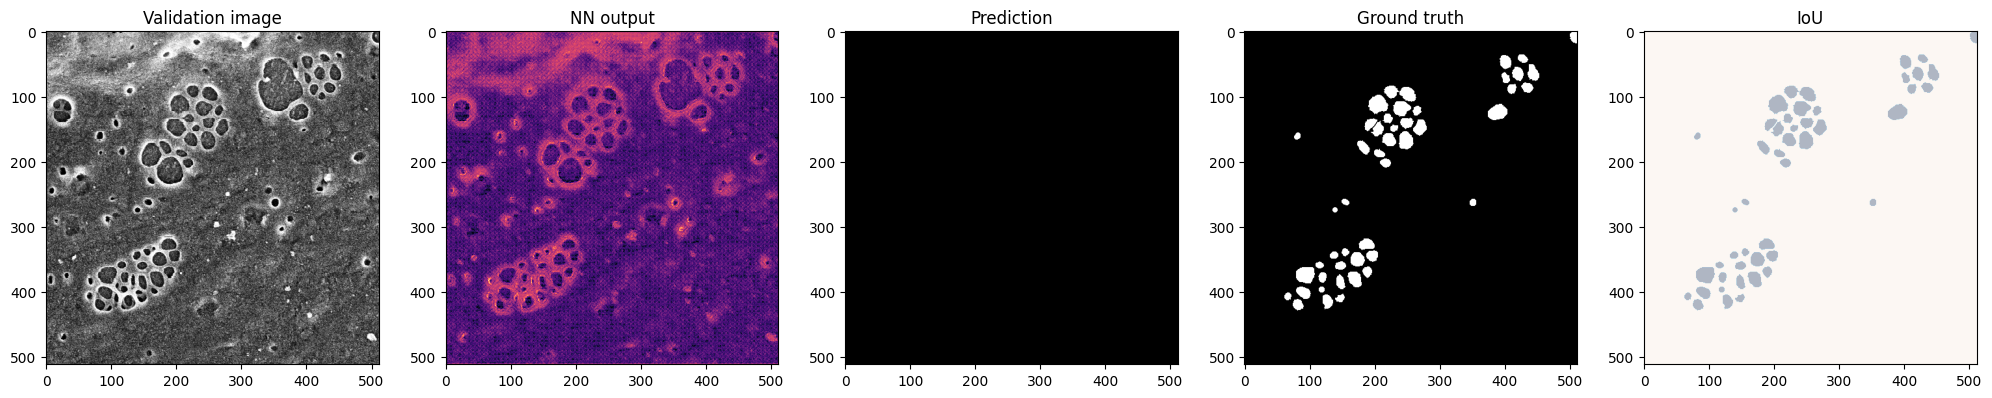

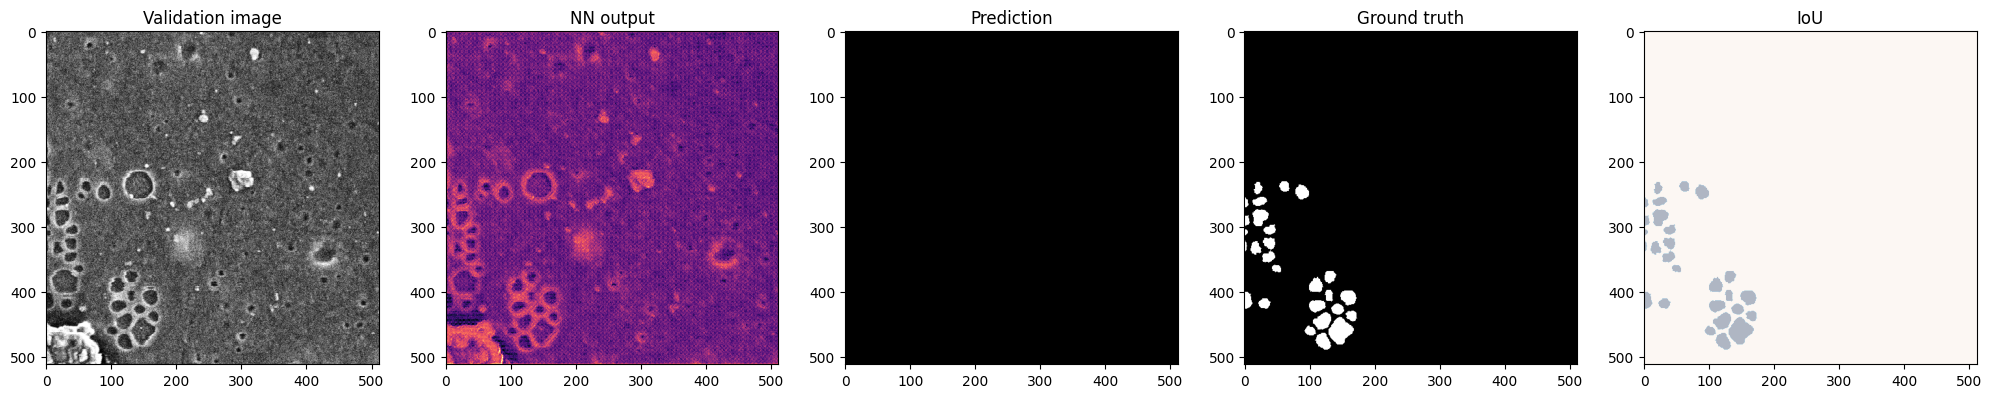

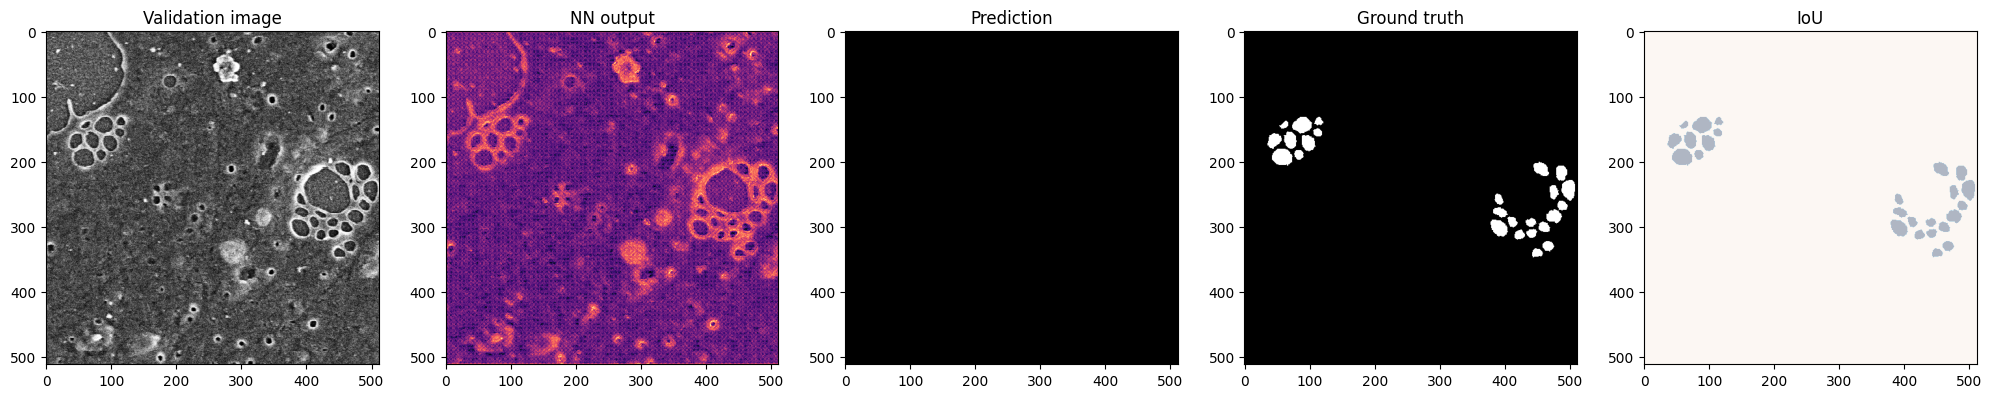

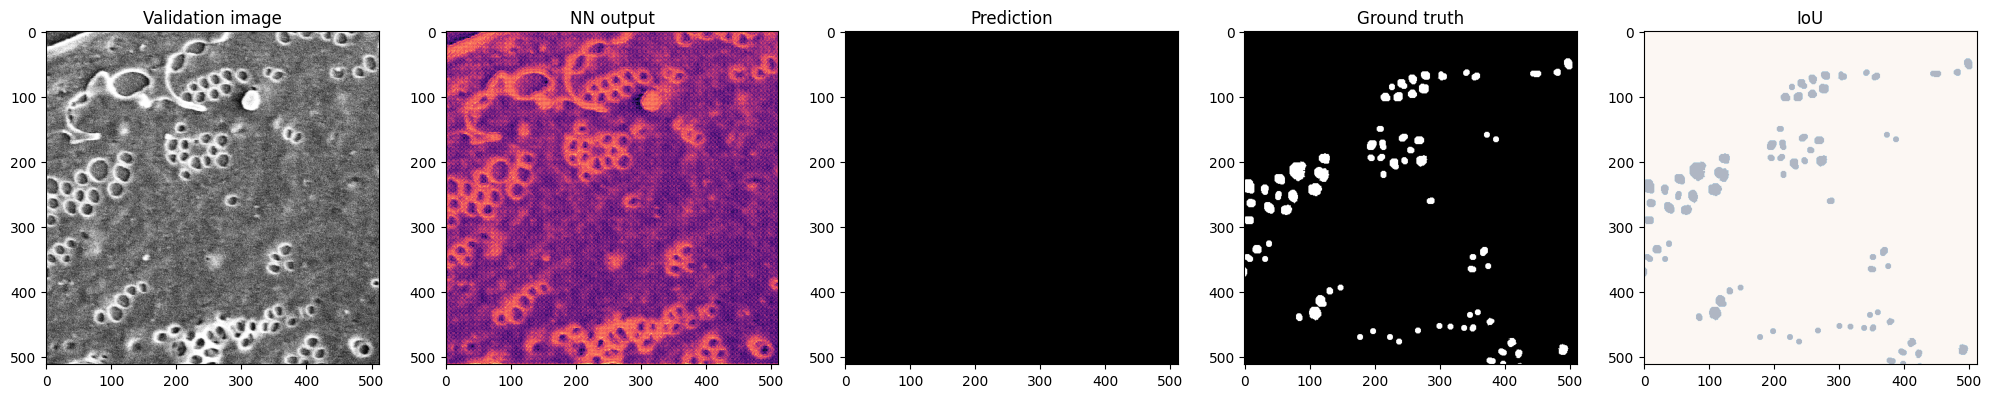

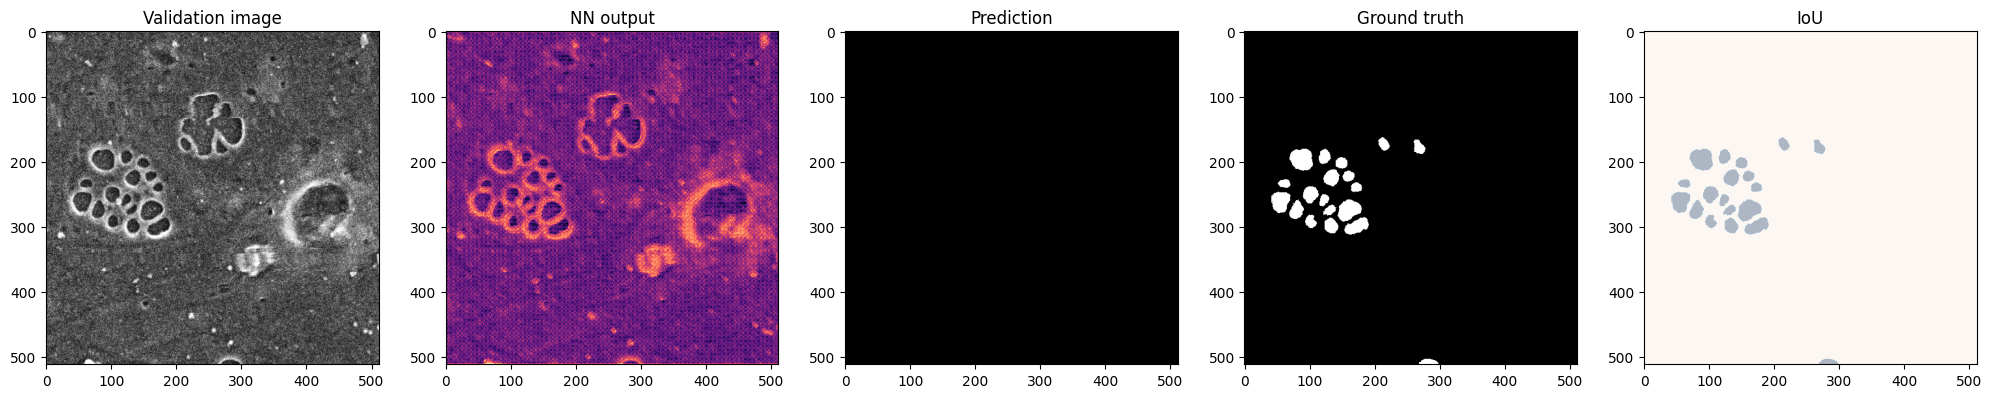

Epoch 1


100%|██████████| 22/22 [00:11<00:00,  1.91it/s, loss=1.15]


Got 2898528/3407872 with acc 85.05 ()
Dice score is 0.4846489131450653
=> Saving checkpoint


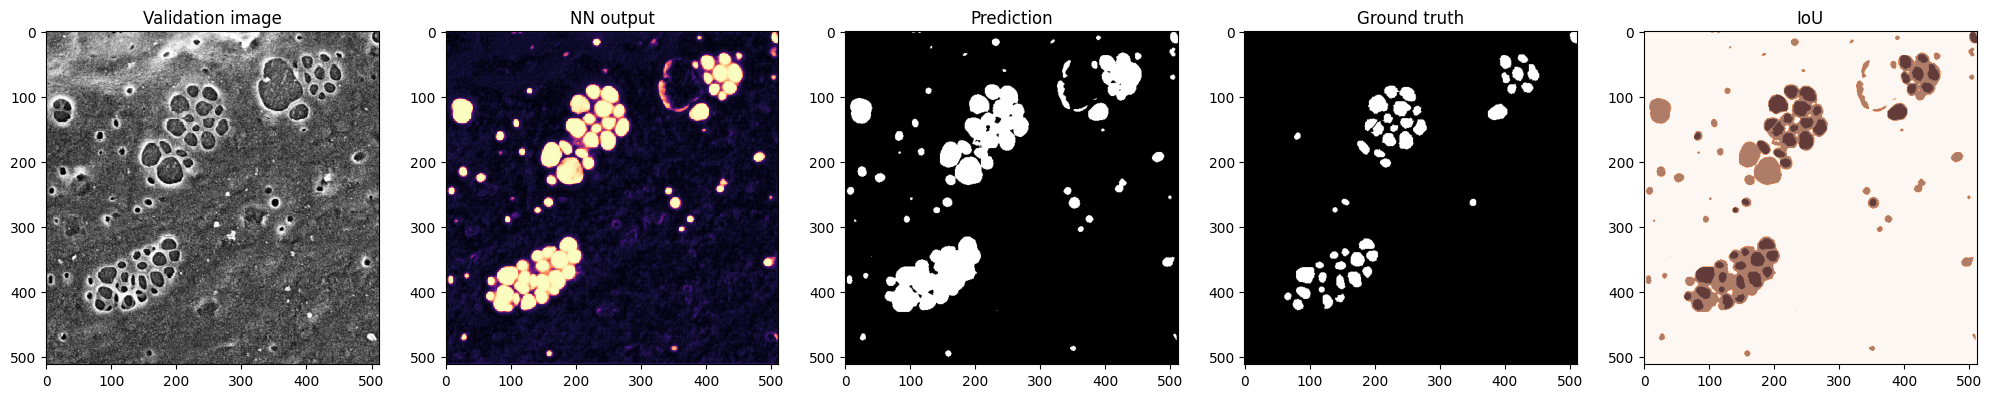

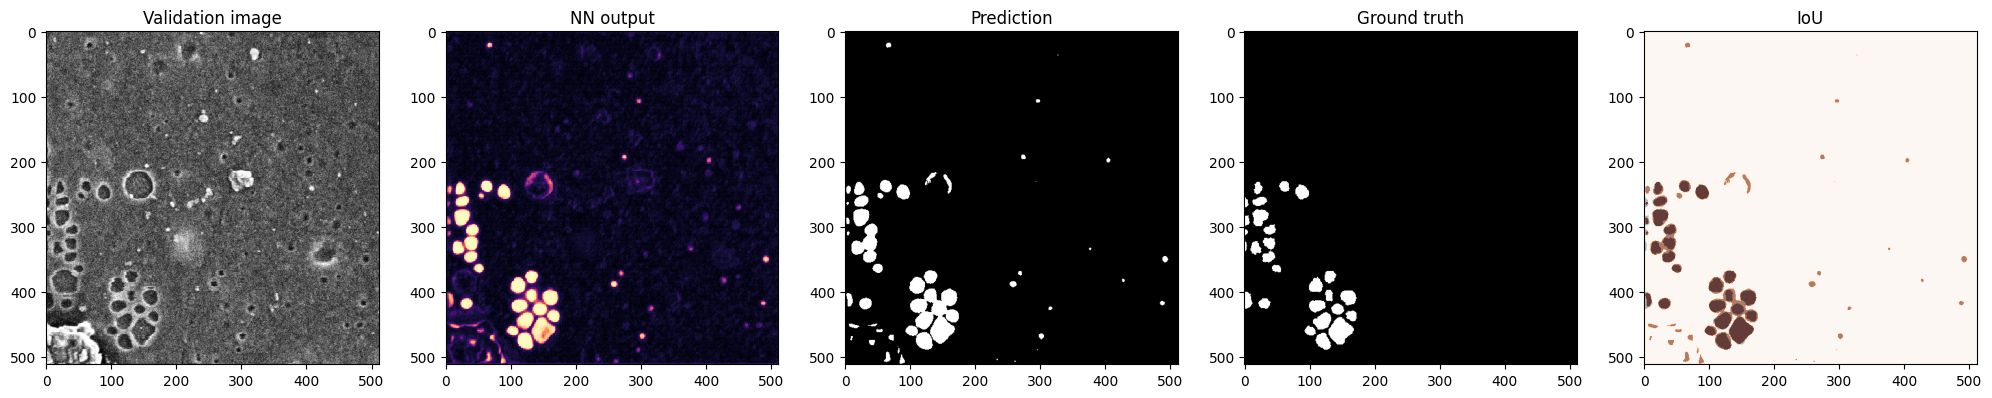

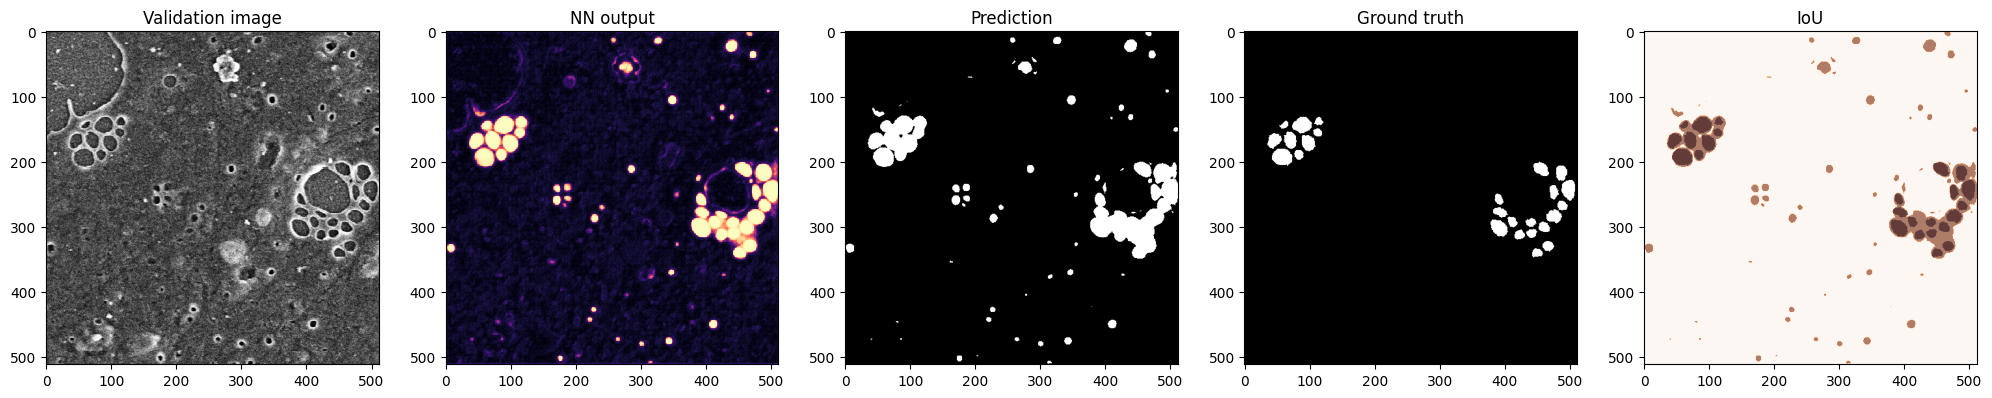

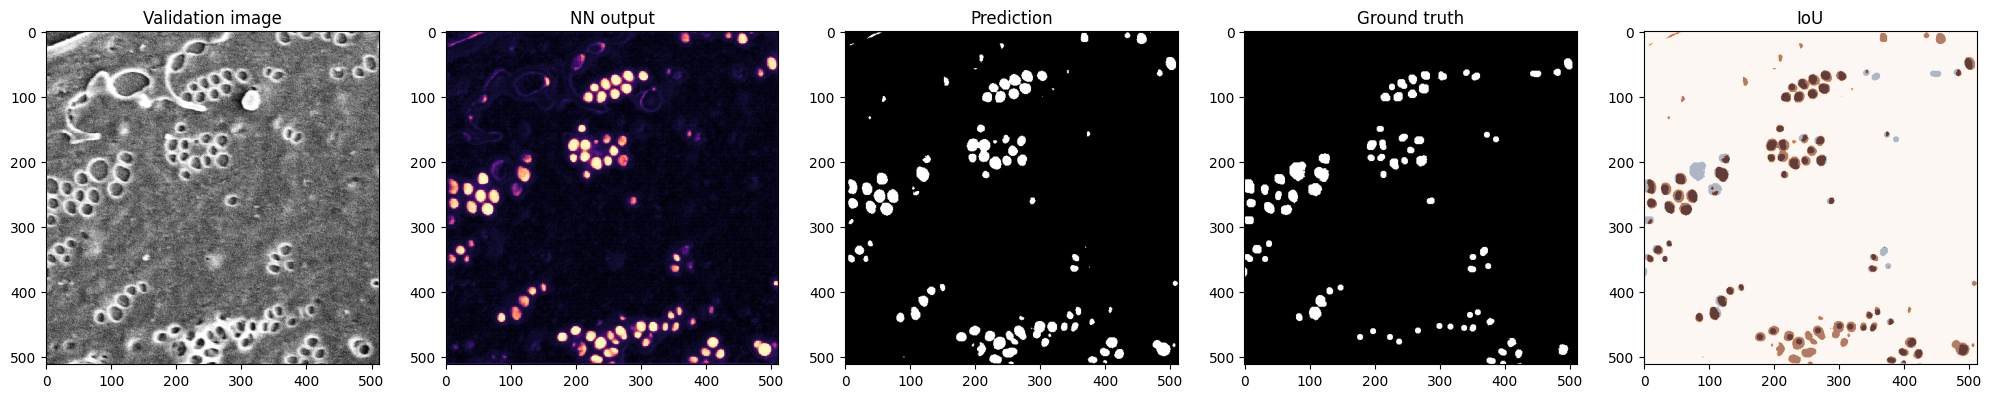

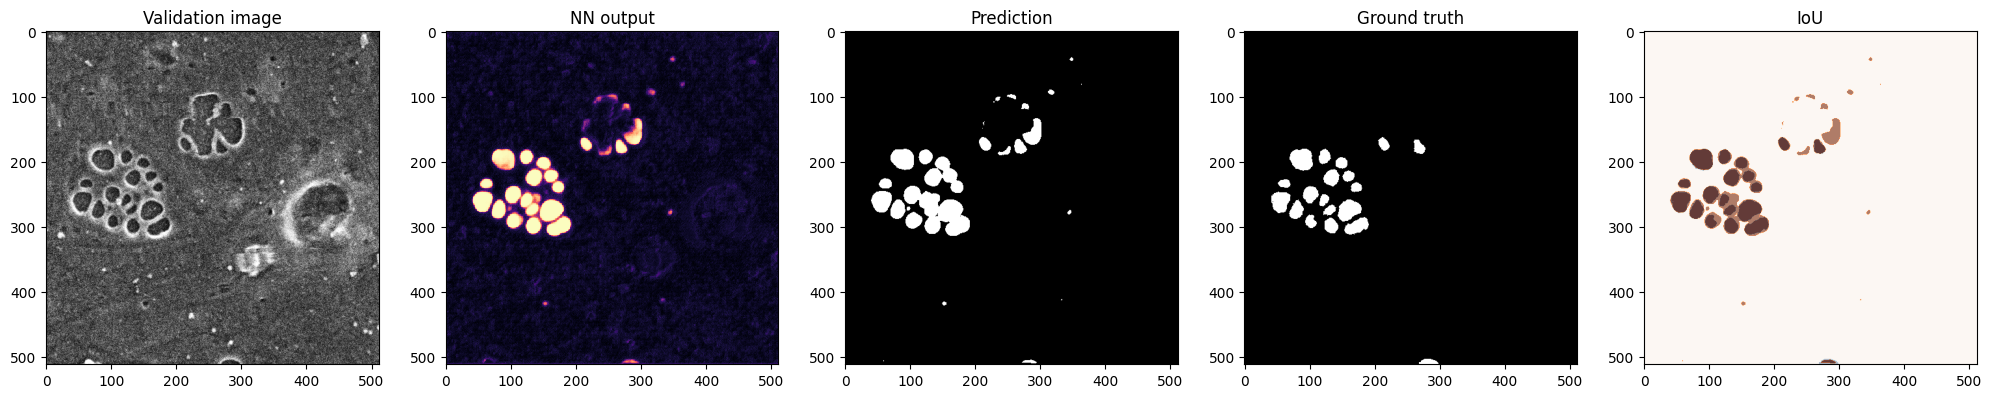

In [223]:
# %%timeit
# if LOAD_MODEL:
#   load_checkpoint(torch.load(os.path.join(model_folder,"my_checkpoint.pth.tar")), model)
#   check_accuracy(val_loader, model, device=DEVICE)
train_losses = []
val_losses = []
dice_scores = []
best_accuracy = 0
for epoch in range(num_epochs):
  print(f"Epoch {epoch}")
  train_fn(train_loader, model, optimizer, loss_fn, scaler, train_losses)

  # save model
  checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict()
  }
  # check accuracy
  accuracy = check_accuracy(val_loader, model, val_losses, dice_scores, DEVICE, loss_fn)
  if accuracy > best_accuracy: # using dice score right now
    save_state_dict(model)
    # save_checkpoint(checkpoint)
  accuracy = max(accuracy, best_accuracy)

  # print some examples to a folder
  # if(epoch % 5 == 0):
  view_prediction(val_loader, model, device = DEVICE)
    # save_predictions_as_imgs(val_loader, model, folder=model_folder, device = DEVICE)

# Training evaluation

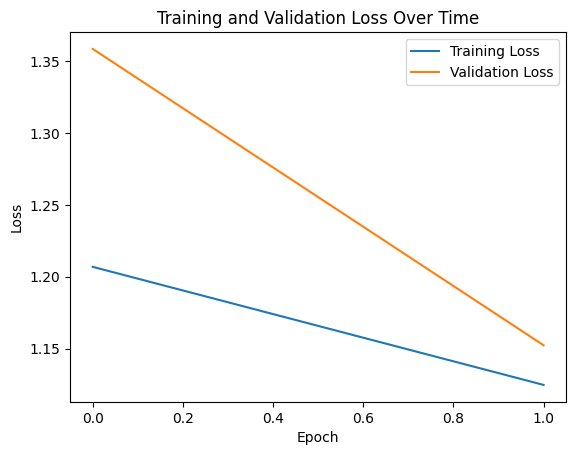

In [224]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

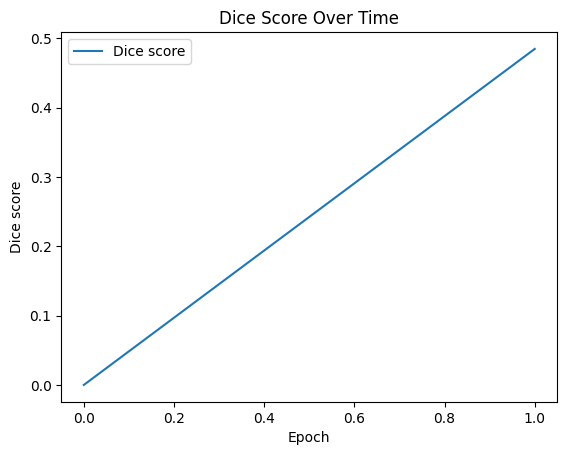

In [225]:
plt.plot(dice_scores, label='Dice score')
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.title('Dice Score Over Time')
plt.legend()
plt.show()

# GitHub

In [266]:
COLAB = True
DOWNLOAD_DATA = True
SAVE_TO_GITHUB = False
GIT_REPOSITORY = "segmentation"
FILE_NAME = "LSEC_image_segmentation.ipynb"

if COLAB:
    PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks"
    # In case you want to clone in your drive:
    # PARENT_DIRECTORY_PATH = "/content/gdrive/My Drive"
    # PROJECT_PATH = PARENT_DIRECTORY_PATH + "/" + GIT_REPOSITORY
    %cd "{PROJECT_PATH}"

[Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Colab Notebooks'
/content


In [267]:
if COLAB:
    %cd /content
    from google.colab import drive
    drive.mount('/content/gdrive')

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [262]:
if COLAB:
    import json

    with open("/content/gdrive/My Drive/Git/git.json", "r") as f:
        parsed_json = json.load(f)

    GIT_USER_NAME = parsed_json["GIT_USER_NAME"]
    GIT_TOKEN = parsed_json["GIT_TOKEN"]
    GIT_USER_EMAIL = parsed_json["GIT_USER_EMAIL"]

    GIT_PATH = (
        f"https://{GIT_TOKEN}@github.com/{GIT_USER_NAME}/{GIT_REPOSITORY}.git"
    )


In [269]:
    # %cd /content
    # from google.colab import drive
    # drive.mount('/content/gdrive')
    %cd "{PROJECT_PATH}"

    !git clone "{GIT_PATH}"  # Clone the github repository

    %cd "{PROJECT_PATH}"

/content/drive/MyDrive/Colab Notebooks
Cloning into 'segmentation'...
/content/drive/MyDrive/Colab Notebooks


In [268]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [270]:
SAVE_TO_GITHUB = True
if SAVE_TO_GITHUB:
    !git add {FILE_NAME}
    !git config --global user.email {GIT_USER_EMAIL}
    !git config --global user.name {GIT_USER_NAME}
    !git commit -am "update {FILE_NAME}"
    !git push

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


# Bioimageio stuff

In [226]:
# !pip install "bioimageio.core>=0.5,<0.6"

In [227]:
# @torch.jit.ignore
# def call_np(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class MyModule(nn.Module):
#     @torch.jit.export
#     def forward(self, tensor):
#         done = call_np(tensor)
#         print (done)

# scripted_module = torch.jit.script(MyModule())
# print(scripted_module.forward.graph)
# empty_tensor = torch.empty(3, 4)
# scripted_module.forward(empty_tensor)










In [228]:
# import torchvision.transforms as transforms
# import numpy as np

# @torch.jit.ignore
# def denoise_image(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class FunctionWrapper(nn.Module):
#   def __init__(self, model):
#     super(FunctionWrapper, self).__init__()
#     self.model = model

#     @torch.jit.export
#     def forward(self, tensor):
#         denoised = denoise_image(tensor)
#         return self.model(denoised)



# device = torch.device('cpu')
# model = UNET(in_channels=1, out_channels=1, device='cpu')
# model.load_state_dict(torch.load(biomodel_path, map_location=device))
# # model.to(device=device)
# model = torch.jit.script(model)
# # wrapper = FunctionWrapper(model)
# wrapper.to(device=device)
# # wrapper = PreprocessingWrapper(denoise, model)
# # model = torch.jit.script(wrapper)
# #
# model.eval()
# torchscript_weights_path = os.path.join(biomodel_folder, 'torchscript_weights.pt')
# torch.jit.save(model, torchscript_weights_path)

# preprocessing=[[{"name": "scale_range",
#                  "kwargs": {"axes": "xy",
#                           #  "min_percentile": min_percentile,
#                             # "max_percentile": max_percentile,
#                             "mode": "per_sample"
#                             }}]]

# threshold = 0.5
# postprocessing = [[{"name": "binarize", "kwargs": {"threshold": threshold}}]]


In [229]:
# input = np.random.rand(1, 1, 512, 512).astype("float32")  # an example input
# test_inputs = os.path.join(biomodel_folder, "test-input.npy")
# test_outputs = os.path.join(biomodel_folder, "test-output.npy")
# np.save(test_inputs, input)
# with torch.no_grad():
#   output = model(torch.from_numpy(input)).cpu().numpy() # copy to cpu(is on gpu because of jit.script)
#   output = output > threshold
# np.save(test_outputs, output)

# print(input.shape)
# print(output.shape)

In [230]:
# # create markdown documentation for your model
# # this should describe how the model was trained, (and on which data)
# # and also what to take into consideration when running the model, especially how to validate the model
# # here, we just create a stub documentation
# doc_path = os.path.join(biomodel_folder, "doc.md")
# with open(doc_path, "w") as f:
#     f.write("# My First Model\n")

In [231]:
# from bioimageio.core.build_spec import build_model
# import torch
# # now we can use the build_model function to create the zipped package.
# # it takes the path to the weights and data we have just created, as well as additional information
# # that will be used to add metadata to the rdf.yaml file in the model zip
# # we only use a subset of the available options here, please refer to the advanced examples and to the
# # function signature of build_model in order to get an overview of the full functionality
# build_model(
#     # the weight file and the type of the weights
#     weight_uri= torchscript_weights_path,
#     weight_type="torchscript",
#     # the test input and output data as well as the description of the tensors
#     # these are passed as list because we support multiple inputs / outputs per model
#     test_inputs=[test_inputs],
#     test_outputs=[test_outputs],
#     input_axes=["bcyx"],
#     output_axes=["bcyx"],
#     # where to save the model zip, how to call the model and a short description of it
#     output_path=os.path.join(biomodel_folder,"model.zip"),
#     name="MyFirstModel",
#     description="a fancy new model",
#     # additional metadata about authors, licenses, citation etc.
#     authors=[{"name": "Gizmo"}],
#     license="CC-BY-4.0",
#     documentation=doc_path,
#     tags=["nucleus-segmentation"],  # the tags are used to make models more findable on the website
#     cite=[{"text": "Gizmo et al.", "doi": "10.1002/xyzacab123"}],
#     pytorch_version=torch.__version__,
#     preprocessing=preprocessing,
#     postprocessing=postprocessing
# )

In [232]:
# # finally, we test that the expected outptus are reproduced when running the model.
# # the 'test_model' function runs this test.
# # it will output a list of dictionaries. each dict gives the status of a different test that is being run
# # if all of them contain "status": "passed" then all tests were successful
# from bioimageio.core.resource_tests import test_model
# import bioimageio.core
# my_model = bioimageio.core.load_resource_description(os.path.join(biomodel_folder,"model.zip"))
# test_model(my_model)